# Blockage modelling 2

## Induction model comparison

This example demonstrates the four different blockage models implemented in *foxes* by producing a 2D flow plot of each and comparing the blockage effect in terms of the centreline windspeeds in front of the turbine along with a profile comparision at 1 diameter upstream.
We start with the following imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

First, we setup the model book and a single turbine of type DTU10MW:

In [2]:
# Selection of a turbine type:
ttype = "DTU10MW"

# create wind farm, a single row of turbines:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_row(
    farm=farm,
    xy_base=[0.0, 0.0],
    xy_step=[0.0, 0.0],
    n_turbines=1,
    turbine_models=[ttype],
    verbosity=0,
)

We choose a single wind direction state of 270 degrees with a wind speed of 8m/s:

In [3]:
# create ambient wind conditions, a single uniform state:
states = foxes.input.states.SingleStateStates(ws=8.0, wd=270.0, ti=0.04, rho=1.225)

Here we set up a list of the induction models to be compared. The models are from the following references:

- SelfSimilar: [Troldborg, Niels, and Alexander Raul Meyer Forsting (2017)](https://onlinelibrary.wiley.com/doi/full/10.1002/we.2137) 
- SelfSimilar2020: [Forsting, Alexander R. Meyer, et al. (2020)](https://www.sciencedirect.com/science/article/pii/S0960148123007620)
- RHB (Rankine Half Body): [B. Gribben and G. Hawkes (2019)](https://www.fnc.co.uk/media/o5eosxas/a-potential-flow-model-for-wind-turbine-induction-and-wind-farm-blockage.pdf)
- Rathmann: [Forsting, Alexander R. Meyer, et al.](https://www.sciencedirect.com/science/article/pii/S0960148123007620)


In [4]:
induction_models = ["SelfSimilar", "SelfSimilar2020", "RHB", "Rathmann"]

The four induction models are run in a loop, with a 2d flow plot for each being generated in a single figure. The maximum and minimum values for the colour scale in the plot are set to a range above and below the ambient wind speed to ensure both reductions and speed ups in wind speed are shown clearly in the flow plots. Within the same loop, data for the centreline and profile plots are being stored.

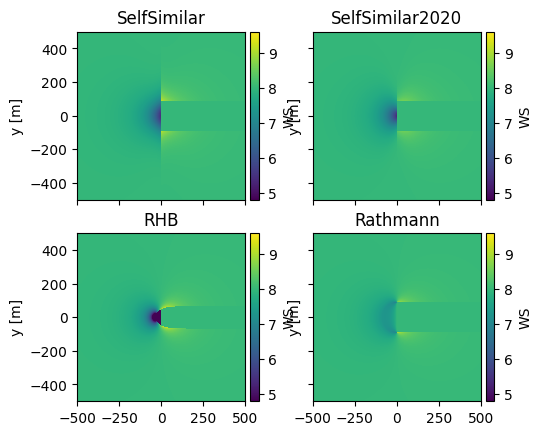

In [5]:
npoints = 10000

# storage for centreline and profile results
centreline_pts = np.ndarray(shape=(npoints, 2, 4))  # points, values, model
profile_pts = np.ndarray(shape=(npoints, 2, 4))

# set up figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
ax = axs.ravel()
vmin = states.ws * 0.6
vmax = states.ws * 1.2

with foxes.Engine.new("process", verbosity=0):
    for i, model in enumerate(induction_models):
        mbook = foxes.ModelBook()
        D = mbook.turbine_types[ttype].D
        H = mbook.turbine_types[ttype].H

        algo = foxes.algorithms.Iterative(
            farm,
            states,
            rotor_model="centre",
            wake_models=[model],
            wake_frame="rotor_wd",
            partial_wakes=None,
            mbook=mbook,
            verbosity=0,
        )
        farm_results = algo.calc_farm()

        # get point data for centreline plot and store
        points = np.zeros((1, npoints, 3))
        points[:, :, 0] = np.linspace(D * -3, D * 1, npoints)[None, :]
        points[:, :, 1] = 0
        points[:, :, 2] = H
        point_results = algo.calc_points(farm_results, points)
        centreline_pts[:, 0, i] = points[0, :, 0] / D  # x points
        centreline_pts[:, 1, i] = point_results[FV.WS].to_numpy()[
            0, :
        ]  # centreline values

        # get point data for profile plot and store in df
        points = np.zeros((1, npoints, 3))
        points[:, :, 0] = -2 * D
        points[:, :, 1] = np.linspace(D * -3, D * 3, npoints)[None, :]
        points[:, :, 2] = H
        point_results = algo.calc_points(farm_results, points)
        profile_pts[:, 0, i] = points[0, :, 1] / D  # x points
        profile_pts[:, 1, i] = point_results[FV.WS].to_numpy()[0, :]  # profile values

        o = foxes.output.FlowPlots2D(algo, farm_results)
        g = o.gen_states_fig_xy(
            var=FV.WS,
            resolution=2,
            fig=fig,
            ax=ax[i],
            vmin=vmin,
            vmax=vmax,
            title=model,
        )
        fig = next(g)
        ax[i].set_xlabel(None)

# finalise fig
fig.subplots_adjust(right=0.8)
plt.show()

In the above plot the four different induction models are shown. The SelfSimilar, SelfSimilar2020 and Rathmann models are all based on a combination of a radial and axial shape function. The axial shape functions are derived from the solution to a rotating semi-infinite vortex cylinder along the centreline. The functions define the blockage effect in front of the rotor only, hence to give a more realistic flow effect behind the rotor, speed up behind and to the sides of the rotor is shown by mirroring the blockage in the rotor plane with the opposite sign. The area directly behind has no wake effect because this example uses no deficit model for the wake behind the turbine.

RHB (Rankine Half Body) is different though, it is based on the concept of a potential flow point source, i.e. the rotor, within a constant flow. The flow gets directed around the point source area, creating a slow-down before the rotor, and a speed to the sides of it.

Below is the centreline comparison is plotted. More than a rotor diameter in front the turbine, the models show a similar blockage effect along the centreline. However, in the region close to the rotor the models vary. This is acceptable for wind farm modelling as we are not interested in the values in this region.

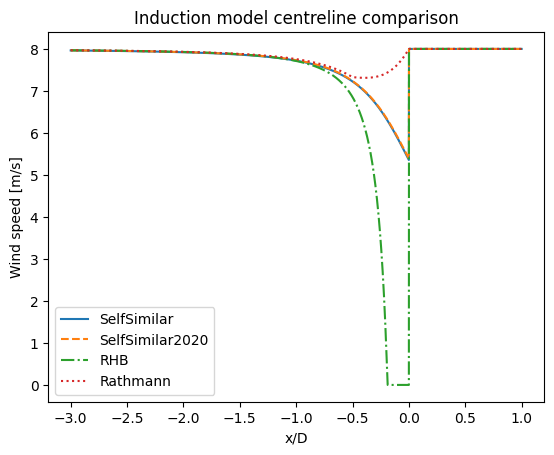

In [6]:
fig, ax = plt.subplots()
lines = ["-", "--", "-.", ":"]
for (
    i,
    model,
) in enumerate(induction_models):
    ax.plot(
        centreline_pts[:, 0, i],
        centreline_pts[:, 1, i],
        label=model,
        linestyle=lines[i],
    )
ax.set_title("Induction model centreline comparison")
ax.set_xlabel("x/D")
ax.set_ylabel("Wind speed [m/s]")
plt.legend()
plt.show()

And finally below we plot the profile comparison at 1 diameter upstream of the rotor. All models show a similar shaped profile at this distance with Rathmann giving the weakest blockage effect, and the SelfSimilar model the strongest.

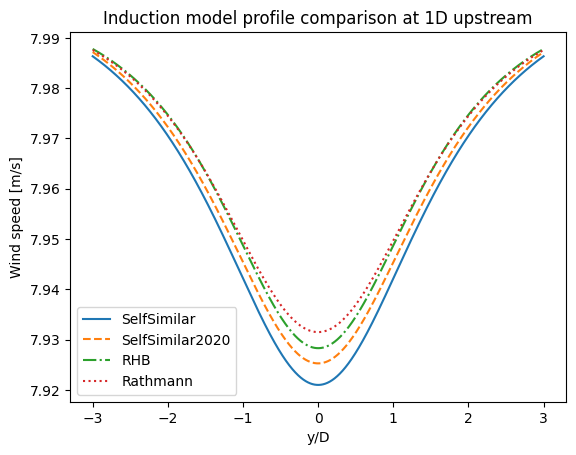

In [7]:
fig, ax = plt.subplots()
lines = ["-", "--", "-.", ":"]
for (
    i,
    model,
) in enumerate(induction_models):
    ax.plot(profile_pts[:, 0, i], profile_pts[:, 1, i], label=model, linestyle=lines[i])
ax.set_title("Induction model profile comparison at 1D upstream")
ax.set_xlabel("y/D")
ax.set_ylabel("Wind speed [m/s]")
plt.legend()
plt.show()